In [1]:
import cv2
from ultralytics import YOLO
import os
import numpy as np
from shapely.geometry import Polygon
from shapely.geometry import box as shapely_box
import matplotlib.pyplot as plt
import easyocr

reader = easyocr.Reader(['ch_sim','en','hi'])
model = YOLO('models/Odometer_OCR_yolov8_runs/train/weights/best.pt')
accepted_odo_labels = ["odometer"]

ModuleNotFoundError: No module named 'shapely'

In [2]:
def checkLargest(result):
    largest_box = None
    car_seg_cords = None
    box_index = 0
    max_area = 0
    bboxes = []
    if len(result)>0:
        for i in range(len(result.boxes)):
            box = result.boxes[i]
            label = result.names[box.cls[0].item()]
            xyxy = box.xyxy[0].tolist()  # Extract coordinates from the list
            x1, y1, x2, y2 = xyxy
            bboxes.append([x1, y1, x2, y2, label])
            if not label.lower() in accepted_odo_labels:
                continue
            area = (x2 - x1) * (y2 - y1)  # Calculate area

            if area > max_area:
                max_area = area
                largest_box = (x1, y1, x2, y2)
                box_index = i
    return largest_box, box_index, bboxes


odo_pos = ['ODO', 'OUO', 'OOO', 'OCO', 'UDO']
replacements = {"k": "", "m": "", "l": "", "i": "", "a": "", "u": "", "I": "1", "T": "1", "S": "5", "O": "0", " ": ""}

def get_kms(ocr):
    for i in range(len(ocr)):
        string = ocr[i].upper()
        for odo_str in odo_pos:
            if odo_str in string:
                if odo_str==string:
                    if i+1<len(ocr):
                        return ocr[i+1]
                    else:
                        return ocr[i-1]
                else:
                    return ocr[i].replace(odo_str, "")
    for i in range(len(ocr)):
        string = ocr[i]
        if len(ocr[i]) in [5, 6]:
            for k, v in replacements.items():
                string = string.replace(k, v)
            if len(string) in [5, 6]:
                return string
    return None

def correct_kms_str(kms_str):
    if kms_str is not None:
        for k, v in replacements.items():
            kms_str = kms_str.replace(k, v)
    return kms_str

In [3]:
img = 'datasets/raw_images/Image.jpeg'
image = cv2.imread(img)
# image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
result = model.predict(img)[0]
largest_box, box_index, bboxes = checkLargest(result)
if largest_box is not None:
    x1, y1, x2, y2 = map(int, largest_box)  # Ensure coordinates are integers
    cropped_image = image[y1:y2, x1:x2]  # Crop the image
else:
    cropped_image = image


image 1/1 /Users/saidhanujnukala/Library/CloudStorage/OneDrive-Mahindra&MahindraLtd/Desktop/vihaan/interior/datasets/raw_images/Image.jpeg: 480x640 2 0s, 2 2s, 1 3, 1 7, 1 9, 7 Xs, 1 odometer, 109.1ms
Speed: 3.0ms preprocess, 109.1ms inference, 6.8ms postprocess per image at shape (1, 3, 480, 640)


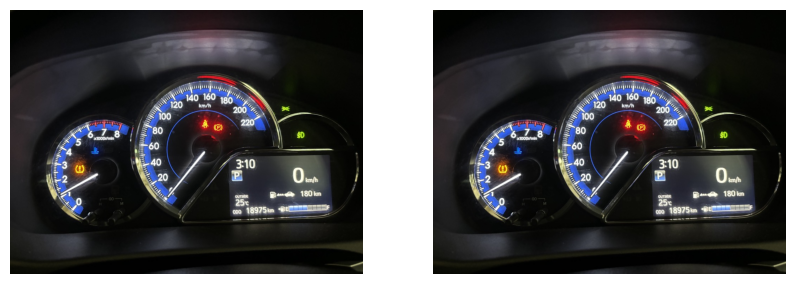

['140 160 186', '120', 'kmih', '200', '100', '220', '8', '80', 'XOODIIII', '60', '40', '3:10', '20', 'Nnhh', 'OTSOE', '180k', '25', 'ODO   18975k'] ['3:10', 'Wnh', '180km', 'ONTSDE', '25c', 'ODO   18975k']
   18975k --- 18975 kms


In [5]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the first image
axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0].axis('off')  # Hide the axis

# Display the second image
axes[1].imshow(cv2.cvtColor(cropped_ocr, cv2.COLOR_BGR2RGB))
axes[1].axis('off')  # Hide the axis

# Show the plot
plt.show()

full_ocr = reader.readtext(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), detail=0)
cropped_ocr = reader.readtext(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB), detail=0)
print(full_ocr, cropped_ocr)

kms_str = get_kms(cropped_ocr)
corr_kms_str = correct_kms_str(kms_str) + ' kms'
print(kms_str, "---", corr_kms_str)

In [ ]:
se=cv2.getStructuringElement(cv2.MORPH_RECT , (8,8))
bg=cv2.morphologyEx(cropped_image, cv2.MORPH_DILATE, se)
out_gray=cv2.divide(cropped_image, bg, scale=255)
out_binary=cv2.threshold(out_gray, 0, 255, cv2.THRESH_OTSU )[1] 

In [ ]:
plt.imshow(cv2.cvtColor(out_gray, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Hide the axis
plt.show()

In [ ]:
ocr = reader.readtext(out_gray, detail=0)
ocr

In [ ]:
plt.imshow(cv2.cvtColor(out_binary, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Hide the axis
plt.show()

In [ ]:
for img_name in os.listdir("datasets/raw_images/odometer/"):
    if img_name[0]==".":
        continue
    img = "datasets/raw_images/odometer/" + img_name
    print(img_name)
    image = cv2.imread(img)
    result = model.predict(img)[0]
    largest_box, box_index, bboxes = checkLargest(result)
    print(bboxes)
    if largest_box is not None:
        x1, y1, x2, y2 = map(int, largest_box)  # Ensure coordinates are integers
        cropped_image = image[y1:y2, x1:x2]  # Crop the image
    else:
        cropped_image = image
    
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))

    # Display the first image
    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].axis('off')  # Hide the axis

    # Display the second image
    axes[1].imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
    axes[1].axis('off')  # Hide the axis

    # Show the plot
    plt.show()
    
    full_ocr = reader.readtext(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), detail=0)
    cropped_ocr = reader.readtext(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB), detail=0)
    print(full_ocr, cropped_ocr)
    
    kms_str = get_kms(cropped_ocr)
    kms_str_corr = correct_kms_str(kms_str)
    print(kms_str, kms_str_corr)
    print("#"*100)